Import necessary library

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

Define needed variable:
IMAGE_SIZE: the size of the image 256 * 256
BATCH_SIZE: the number of image in each batch
EPOCHS: the number of times to train the model
CHANNELS: RGB

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 25
CHANNELS = 3

Load images to dataset

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../dataImage/",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1125 files belonging to 15 classes.


The size of the dataset, which makes sense. 1125 < 32*36 = 1152 < 1157.

In [6]:
len(dataset)

36

The class name which will be used later

In [7]:
class_name = dataset.class_names
class_name

['Acer',
 'Alnus incana',
 'Betula pubescens',
 'Fagus silvatica',
 'Populus',
 'Populus tremula',
 'Quercus',
 "Salix alba 'Sericea'",
 'Salix aurita',
 'Salix sinerea',
 'Sorbus aucuparia',
 'Sorbus intermedia',
 'Tilia',
 'Ulmus carpinifolia',
 'Ulmus glabra']

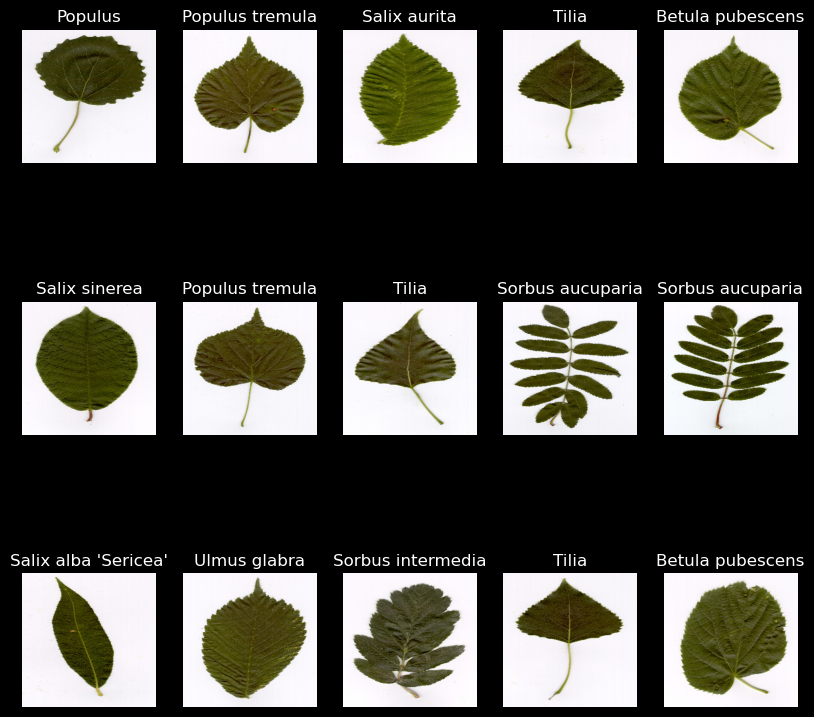

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

Divide dataset into train_ds, validation_ds, and test_ds

In [9]:
int(len(dataset) * 0.7)

25

In [10]:
train_ds = dataset.take(25)
val_ds = dataset.skip(25).take(6)
test_ds = dataset.skip(25).skip(6)
print(f"the size of train_ds {len(train_ds)} \nthe size of val_ds {len(val_ds)} \nthe size of test_ds {len(test_ds)}")

the size of train_ds 25 
the size of val_ds 6 
the size of test_ds 5


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE)),
    #layers.Conv2D(64, (3,3), activation='relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE)),
    layers.MaxPooling2D((2,2)),
    #layers.Conv2D(64, (3,3), activation='relu'),
    #layers.MaxPooling2D((2,2)),
    #layers.Conv2D(64, (3,3), activation='relu'),
    #layers.MaxPooling2D((2,2)),
    #layers.Conv2D(128, (3,3), activation='relu', input_shape = (128, 128)),
    layers.Conv2D(128, (3,3), activation='relu', input_shape = (128, 128)),
    layers.MaxPooling2D((2,2)),
    #layers.Conv2D(256, (3,3), activation='relu', input_shape = (64, 64)),
    layers.Conv2D(256, (3,3), activation='relu', input_shape = (64, 64)),
    #layers.Conv2D(256, (3,3), activation='relu', input_shape = (64, 64)),
    #layers.Conv2D(256, (3,3), activation='relu', input_shape = (64, 64)),
    layers.MaxPooling2D((2,2)),
    #layers.Conv2D(512, (3,3), activation='relu', input_shape = (32, 32)),
    layers.Conv2D(512, (3,3), activation='relu', input_shape = (32, 32)),
    #layers.Conv2D(512, (3,3), activation='relu', input_shape = (32, 32)),
    #layers.Conv2D(512, (3,3), activation='relu', input_shape = (32, 32)),
    layers.MaxPooling2D((2,2)),
    #layers.Conv2D(512, (3,3), activation='relu', input_shape = (16, 16)),
    #layers.Conv2D(512, (3,3), activation='relu', input_shape = (16, 16)),
    #layers.Conv2D(512, (3,3), activation='relu', input_shape = (16, 16)),
    #layers.Conv2D(512, (3,3), activation='relu', input_shape = (16, 16)),
    #layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape= input_shape)

In [23]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [24]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data=val_ds
)

Epoch 1/25
25/25 [==============================] - 23s 828ms/step - loss: 2.4343 - accuracy: 0.1813 - val_loss: 1.7629 - val_accuracy: 0.4479
Epoch 2/25
25/25 [==============================] - 19s 753ms/step - loss: 1.4932 - accuracy: 0.5138 - val_loss: 1.1015 - val_accuracy: 0.5885
Epoch 3/25
25/25 [==============================] - 19s 758ms/step - loss: 1.0375 - accuracy: 0.6500 - val_loss: 0.9753 - val_accuracy: 0.6979
Epoch 4/25
25/25 [==============================] - 20s 804ms/step - loss: 0.8061 - accuracy: 0.7225 - val_loss: 0.8644 - val_accuracy: 0.7135
Epoch 5/25
25/25 [==============================] - 20s 798ms/step - loss: 0.7028 - accuracy: 0.7563 - val_loss: 0.7508 - val_accuracy: 0.7656
Epoch 6/25
25/25 [==============================] - 19s 774ms/step - loss: 0.6804 - accuracy: 0.7613 - val_loss: 0.8174 - val_accuracy: 0.7760
Epoch 7/25
25/25 [==============================] - 19s 771ms/step - loss: 0.6456 - accuracy: 0.7700 - val_loss: 0.7575 - val_accuracy: 0.7448

In [26]:
acc = history.history['accuracy']
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

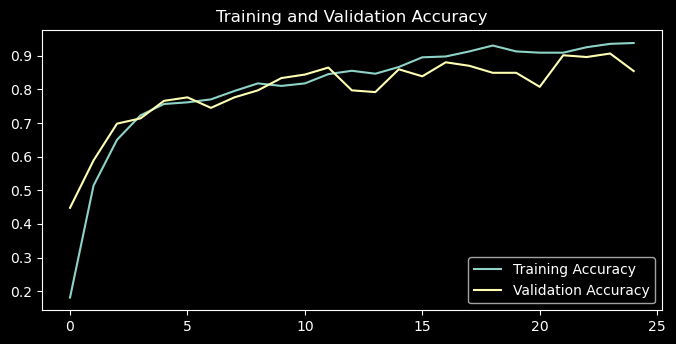

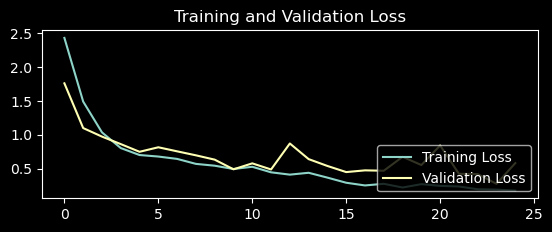

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,2)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")
plt.show()

plt.subplot(2,1,2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'lower right')
plt.title("Training and Validation Loss")
plt.show()

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


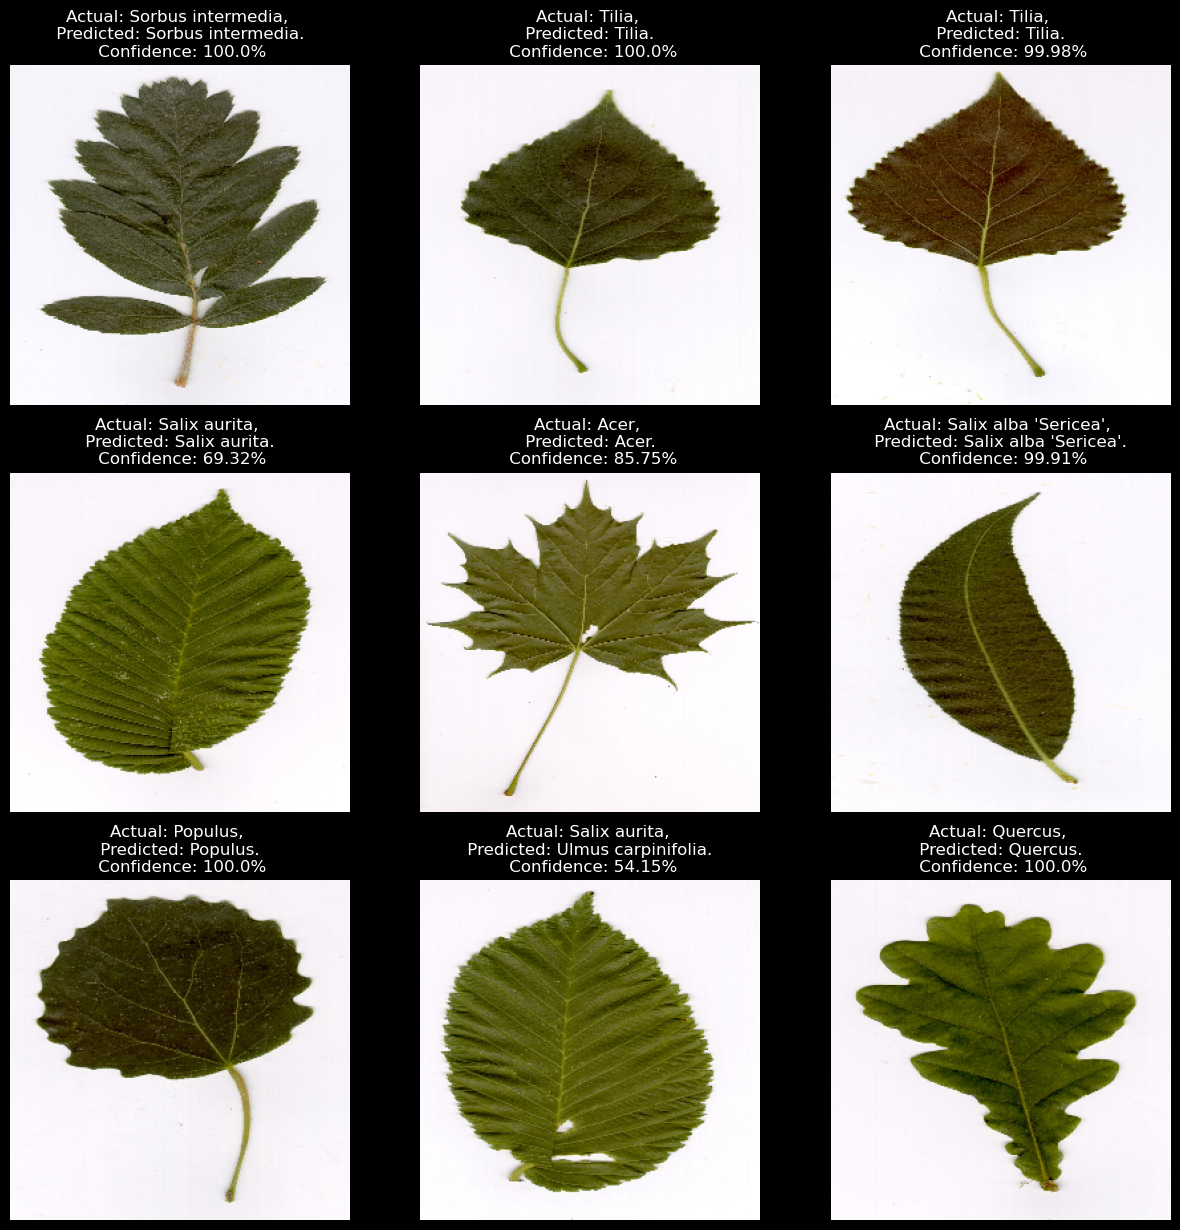

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis("off")